# EDS232 Lab 2: Regularized Regression and Energy Modeling


## Overview
In this lab, you will explore Ridge Regression and Lasso Regression, two common techniques for regularized regression. Both methods add penalties to the standard regression coefficients, which can help prevent overfitting and improve model interpretability.

## Key Concepts

**Types of Regularization:**

- Ridge Regression:

    - Adds an L2 penalty ($\lambda \sum_{j=1}^p \beta_j^2 $) to the regression loss function.
    - Shrinks coefficients toward zero but does not set any coefficients exactly to zero.
    - Best suited for reducing multicollinearity and improving model stability.

- Lasso Regression:

    - Adds an L1 penalty ($\lambda \sum_{j=1}^p |\beta_j|$) to the regression loss function.
    - Can shrink some coefficients to exactly zero, effectively performing feature selection.
    - Useful when you want a simpler, interpretable model.

**Cross-Validation**

- Cross-validation is a method for model evaluation and hyperparameter tuning.  In this lab we will be tuning $\lambda$, which controls the penalty terms.

- Note: Sci-kit learn refers to $\lambda$, the regularization penalty hyperparameter, as "alpha" instead of "lambda" 


## About the data

Buildings account for a significant portion of global energy consumption. Effective energy modeling and analysis are critical for designing energy-efficient buildings, reducing greenhouse gas emissions, and meeting sustainability goals. 

- This dataset contains energy performance data for 768 different building configurations, generated through simulation using Ecotect software. These configurations vary across multiple architectural features:

| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------|
| Relative Compactness        | A measure of how compact the building's shape is.                                             |
| Surface Area                | The total external surface area of the building.                                              |
| Wall Area                   | The total area of the walls.                                                                  |
| Roof Area                   | The area of the roof.                                                                         |
| Overall Height              | The height of the building.                                                                   |
| Orientation                 | The direction the building faces (categorical, encoded numerically).                         |
| Glazing Area                | The percentage of the building’s facade that is glass.                                        |
| Glazing Area Distribution   | The distribution of the glazing area (e.g., evenly distributed or concentrated on one side). |
| Heating Load (Y1)           | Continuous target variable representing heating energy requirements. (This is the one we'll use for today's lab.) |
| Cooling Load (Y2)           | Continuous target variable representing cooling energy requirements. (We won't be using this one.) |

[More information on the data set available here.](https://archive.ics.uci.edu/dataset/242/energy+efficiency)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from ucimlrepo import fetch_ucirepo 


### Step 1: Fetch  dataset 
Grab the data from the UC Irvine Machine Learning Repository using fetch_ucrepo.  Note that the object returned contains both tabular data as well as metadata.  We'll need to add column names to the tabular data.

In [2]:
# Fetch dataset
energy_efficiency = fetch_ucirepo(id=242)

# Specify column names as a list of names from the metadata
feature_names = ["Relative Compactness",
    "Surface Area",
    "Wall Area",
    "Roof Area",
    "Overall Height",
    "Orientation",
    "Glazing Area",
    "Glazing Area Distribution",]

# Add feature_names as column names in energy_efficiency.data
energy_efficiency.data['features'].columns = feature_names

# Rename the columns in the 'targets' table to 'Heating Load' and 'Cooling Load'
energy_efficiency.data['targets'].columns = ["Heating Load", "Cooling Load"]

# Rename the 'Heating Load' column from the 'targets' table and assign it to `heating_load`
heating_load = energy_efficiency.data['targets']["Heating Load"]

# Print the type for the energy_efficiency data
print(type(energy_efficiency.data))


<class 'ucimlrepo.dotdict.dotdict'>


### Step 2: Preprocess the data
Split the data into training and test sets **using a 70/30 split and a random state value of 42**. Then scale the data using StandardScaler.

In [3]:

# Assign predictor and outcome variables 
X = energy_efficiency.data.features
Y = heating_load

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Step 3: Initial model fits
We'll start by fitting a simple ordinary least squared regression model for comparison purposes.  Then we'll fit an initial ridge regression model. Let's start by choosing 10 as an arbitrary value for alpha. Recall that we can access coefficients from a model instance with `model_name.coef_`. 


In [4]:
# Create OLS instance and fit it
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

# Define a fixed alpha (lambda)
alpha_fixed = 10 

# Create Ridge regression instance and fit it
ridge = Ridge(alpha=alpha_fixed)

# Fit ridge model to training data
ridge.fit(X_train_scaled, y_train)

# Check coefficients of the OLS and ridge models
print("OLS Coefficients:", ols.coef_)
print("Ridge Coefficients:", ridge.coef_)


OLS Coefficients: [-6.68692391 -3.70147238  0.76114173 -3.99242943  7.21681807 -0.02606662
  2.6700316   0.35604219]
Ridge Coefficients: [-2.47753304 -1.43512945  1.71819798 -2.24012431  6.98517033 -0.02697343
  2.64233342  0.3579727 ]


Is the penalty term doing its job?  How can you tell?

Based on the differences between the OLS coefficients and the Ridge coefficients, it does appear that the penalty is doing its job. I am inclined to think this as the Ridge coefficients have reduced magnitude and are closer to 0 (but not at 0) than the OLS coefficients. 

### Step 4: Evaluate ridge model
Now let's use our ridge model to make predictions and evaluate it using MSE. **Be sure to print your results.**

In [5]:
# Predictions using ridge model
y_train_pred = ridge.predict(X_train_scaled)
y_test_pred = ridge.predict(X_test_scaled)

# Evaluate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE: (alpha = {alpha_fixed}): {mse_train:.4f}")
print(f"Test MSE: (alpha = {alpha_fixed}): {mse_test:.4f}")

# The model did better on training data than on the test data

Train MSE: (alpha = 10): 8.7248
Test MSE: (alpha = 10): 9.9576


### Step 5: Cross-validation with ridge
Now let's move to a more sophisticated version of a ridge regression model using cross-validation using the RidgeCV class.  Let's try models with 0.1, 1.0, and 10.0 as values of alpha. Of the alpha parameter values we try, the model will save the that yielded the best MSE in the `_cv.alpha_` attribute.

In [6]:
# Try more values with the alpha parameter
# Define the three alpha values
alphas = [0.1, 1.0, 10.0]

# Fit RidgeCV
ridge_cv = RidgeCV(alphas = alphas, cv=10).fit(X_train_scaled, y_train)

# Print best alpha
print(f"Best alpha {ridge_cv.alpha_}")

# Evaluate model with the best alpha
y_test_pred_cv = ridge_cv.predict(X_test_scaled)

# Test the mse
mse_test_cv = mean_squared_error(y_test, y_test_pred_cv)

print(f"Test MSE with best alpha: {mse_test_cv:.3f}")

# It is slightly better, mse is only ten so .5 is .5 % better

Best alpha 1.0
Test MSE with best alpha: 9.547


### Step 6: Fit ridge models to a large range of alpha values 
Now we are going to dig a little deeper to see alpha's effect on the model coefficients. Let's define a larger range of alphas to try on a log scale with np.logspace(). Let's use 100 values ranging between -4 and 4.  Then using a for loop, we'll fit a Ridge model for each of those values of alpha, appending each model's coefficients (`coefficients.append()`) as we go.

In [7]:
# Define alphas for ridge regression. Initialize an empty list to hold our coefficients
alphas = np.logspace(-4, 4, num= 100) # Alphas from 0.0001 to 10,000
coefficients = []

# Fit a ridge model for each alpha and collect coefficients
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefficients.append(ridge.coef_)

# Convert coefficients to numpyarray
coefficients = np.array(coefficients)

### Step 7: Plot ridge coefficients vs. lambda

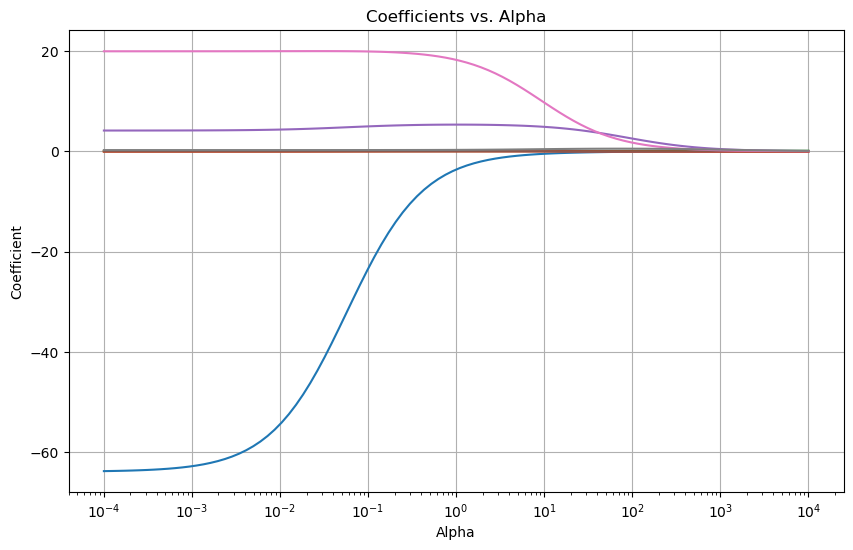

In [8]:
# Plot coefficients vs. alpha values
plt.figure(figsize=(10, 6))
# For loop to plot coef v alphas
for i in range(coefficients.shape[1]):  
    plt.plot(alphas, coefficients[:, i], label=f'Feature {i+1}')

# Set x-axis to log scale    
plt.xscale('log')

# Label parts of the graph
plt.xlabel('Alpha')
plt.ylabel('Coefficient')
plt.title('Coefficients vs. Alpha')

# Add background grid 
plt.grid(True)

plt.show()


### Step 8: Run a full cross-validated ridge model using RidgeCV

In [9]:
# Fit a RidgeCV with cross-validation
ridge_cv = RidgeCV(alphas=alphas, cv=10).fit(X_train_scaled, y_train)
print(ridge_cv)

# Print the optimal alpha and coefficients corresponding to that alpha
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Evaluate the model on the test set by predicting..
y_test_pred = ridge_cv.predict(X_test_scaled)

# ... and printing the MSE
mse = mean_squared_error(y_test, y_test_pred)
print(mse)

RidgeCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=10)
Best alpha: 0.521400828799969
9.526684864663936


### Step 9: Fit lasso regression using LassoCV

In [10]:
# Fit lasso regression with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=10).fit(X_train_scaled, y_train)

# Print the optimal alpha and associated coefficients
lasso_alpha = lasso_cv.alpha_
print(f"Best lasso alpha: {lasso_alpha}")

# Print coefficients of optimal alpha
print(f'Assoc Coef: {lasso_cv.coef_}')

Best lasso alpha: 0.0016297508346206433
Assoc Coef: [-6.4183303  -6.23103457  2.15252392 -1.04432391  7.30915974 -0.0235928
  2.67019427  0.35497087]


### Step 10: The "one-standard error" rule 
We can use 1-SE rule to trade off a small amount of accuracy for increased model simplicity and interpretability.  To do so, find the highest penalty value that falls within 1 standard error of the minimum MSE.  Hopefully it will reduce the number of features in the model.

In [11]:
# Avoid overfitting by getting the largest alpha value within 1 standard error of the min MSE
lasso_best_alpha_1se = lasso_cv.alphas_[np.where(
    lasso_cv.mse_path_.mean(axis=1) <= (lasso_cv.mse_path_.mean(axis=1).min() + lasso_cv.mse_path_.std(axis=1).mean())
)[0][0]]

# Fit a Lasso with this new alpha
lasso_lse_model = Lasso(alpha=lasso_best_alpha_1se)
lasso_lse_model.fit(X_train_scaled, y_train)

# Identify remaining features for 1-SE rule (those with non-zero coefficients)
# Make an empty list
remaining_feats_lse = []

# Make a for loop to match feature names to non-zero coefficients and check for positive coefficients
for feature, coeff in zip(feature_names, lasso_lse_model.coef_):
    if coeff > 0:
        remaining_feats_lse.append((feature, coeff))

# Print the remaining features
print(remaining_feats_lse)

# Evaluate the Lasso model on the test set by predicting...
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

# ...and printing the MSE for Lasso model
mse = mean_squared_error(y_test, y_test_pred_lasso)
print(f"Test MSE with best alpha: {mse:.4f}")
print(mse)

[('Wall Area', 1.2044824249961135), ('Overall Height', 7.295537926556381), ('Glazing Area', 1.4602278930070884)]
Test MSE with best alpha: 9.5150
9.515003847649236


### Step 11: Compare the performance of your ridge and lasso regression models.


The lasso model performed better than the ridge model. This can be seen in their alpha scores. The ridge model had a best MSE alpha value of 9.526684864663936, and the lasso model had a best MSE alpha value of 9.515003847649236. The two models had a difference of 0.01168101701, which is small, but it is still a difference! The lasso model MSE value was closer to 0, which implies it will do better at predicitons.